In [8]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np

path = '/home/hao/Project/uni-cmae/egs/MAFW/cross_validation/fold_1_train_weights.npy'

data = np.load(path)
print(data.shape)

(7324,)


In [45]:
import torch
import models
from torchinfo import summary

# 定义一个包装类来封装模型
class WrappedModel(torch.nn.Module):
    def __init__(self, model, mode):
        super(WrappedModel, self).__init__()
        self.model = model
        self.mode = mode

    def forward(self, audio, video):
        return self.model(audio, video, mode=self.mode)

# 初始化模型和优化器
audio_model = models.Uni_CMAEFT(img_size=160, audio_length=1024, label_dim=10, encoder_depth=12)
optimizer = torch.optim.Adam(audio_model.parameters(), lr=0.0001)

# 生成随机输入数据
audio = torch.randn(1, 1024, 128)
video = torch.randn(1, 3, 16, 160, 160)

# 前向传播
loss = audio_model(audio, video, mode='multimodal')

loss = loss.mean()
# 反向传播
loss.backward()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 使用包装类来封装模型
wrapped_model = WrappedModel(audio_model, mode='multimodal').to(device)

# 使用 torchinfo 评估模型的计算量和参数量
summary(wrapped_model, input_data=(audio.to(device), video.to(device)), device=str(device))

# # 检查梯度是否计算正确
# for name, param in audio_model.named_parameters():
#     if param.grad is None:
#         print(f"参数 {name} 没有梯度")
#     else:
#         pass
#         #print(f"参数 {name} 的梯度正常")

# # 保存参数的初始值
# initial_params = {name: param.clone() for name, param in audio_model.named_parameters()}

# # 更新参数
# optimizer.step()

# # 检查参数是否更新
# for name, param in audio_model.named_parameters():
#     if not torch.equal(param, initial_params[name]):
#         pass
#         #print(f"参数 {name} 已更新")
#     else:
#         print(f"参数 {name} 未更新")

img_size (160, 160) patch_size (16, 16) frames 16 t_patch_size 2
Number of Audio Patches: 512, Visual Patches: 800
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 8, 100, 768])


Layer (type:depth-idx)                   Output Shape              Param #
WrappedModel                             [1, 10]                   --
├─Uni_CMAEFT: 1-1                        [1, 10]                   1,095,168
│    └─Tokenizer_audio: 2-1              [1, 512, 768]             --
│    │    └─Conv2d: 3-1                  [1, 768, 8, 64]           197,376
│    └─Tokenizer_video: 2-2              [1, 8, 100, 768]          --
│    │    └─Conv3d: 3-2                  [1, 768, 8, 10, 10]       1,180,416
│    └─ModuleList: 2-3                   --                        --
│    │    └─Block: 3-3                   [1, 512, 768]             7,087,872
│    │    └─Block: 3-4                   [1, 800, 768]             (recursive)
│    │    └─Block: 3-5                   [1, 512, 768]             7,087,872
│    │    └─Block: 3-6                   [1, 800, 768]             (recursive)
│    │    └─Block: 3-7                   [1, 512, 768]             7,087,872
│    │    └─Block: 3-8     

: 

In [ ]:
import torch
import models
from torchviz import make_dot

# 初始化模型和优化器
audio_model = models.Uni_CMAE(img_size=160, audio_length=1024, norm_pix_loss=True, encoder_depth=12, pred_t_dim=16)
optimizer = torch.optim.Adam(audio_model.parameters(), lr=0.0001)

# 生成随机输入数据
audio = torch.randn(1, 1024, 128)
video = torch.randn(1, 3, 16, 160, 160)

# 前向传播
loss, loss_mae, loss_mae_a, loss_mae_v, loss_c, mask_a, mask_v, c_acc = audio_model(audio, video)

# 生成简化的计算图
model_graph = make_dot(loss, params=dict(audio_model.named_parameters()), show_attrs=False, show_saved=False)
model_graph.format = 'png'
model_graph.render('model_graph')

# 显示计算图
from IPython.display import Image
Image(filename='model_graph.png')

In [36]:
import torch
import models
from torchinfo import summary

# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型并移动到设备
audio_model = models.Uni_CMAE(img_size=160, audio_length=1024, norm_pix_loss=True, encoder_depth=12, pred_t_dim=16).to(device)
optimizer = torch.optim.Adam(audio_model.parameters(), lr=0.0001)

# 生成随机输入数据并移动到设备
audio = torch.randn(5, 1024, 128).to(device)
video = torch.randn(5, 3, 16, 160, 160).to(device)

# 前向传播
loss, loss_mae, loss_mae_a, loss_mae_v, loss_c, mask_a, mask_v, c_acc = audio_model(audio, video)

loss = loss.mean()
# 反向传播
loss.backward()

# 使用 torchinfo 评估模型的计算量和参数量
summary(audio_model, input_data=(audio, video), device=str(device))

A Uni-CMAE Model
Use norm_pix_loss:  True
Learnable Positional Embedding:  False
img_size (160, 160) patch_size (16, 16) frames 16 t_patch_size 2
Number of Audio Patches: 512, Visual Patches: 800
pos_embed_v_t shape: torch.Size([1, 8, 768])
pos_embed_v_s shape: torch.Size([1, 100, 768])
pos_embed_v shape: torch.Size([1, 8, 100, 768])
decoder_pos_embed_v_t shape: torch.Size([1, 8, 384])
decoder_pos_embed_v_s shape: torch.Size([1, 100, 384])
decoder_pos_embed_v shape: torch.Size([1, 8, 100, 384])
decoder_pos_embed_v_trans shape: torch.Size([1, 800, 384])
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 8, 100, 768])


Layer (type:depth-idx)                   Output Shape              Param #
Uni_CMAE                                 --                        1,945,728
├─Tokenizer_audio: 1-1                   [5, 512, 768]             --
│    └─Conv2d: 2-1                       [5, 768, 8, 64]           197,376
├─Tokenizer_video: 1-2                   [5, 8, 100, 768]          --
│    └─Conv3d: 2-2                       [5, 768, 8, 10, 10]       1,180,416
├─ModuleList: 1-3                        --                        --
│    └─Block: 2-3                        [5, 256, 768]             --
│    │    └─LayerNorm: 3-1               [5, 256, 768]             1,536
│    │    └─Attention: 3-2               [5, 256, 768]             2,362,368
│    │    └─Identity: 3-3                [5, 256, 768]             --
│    │    └─LayerNorm: 3-4               [5, 256, 768]             1,536
│    │    └─Mlp: 3-5                     [5, 256, 768]             4,722,432
│    │    └─Identity: 3-6                [5, 2

In [19]:
import torch
import models
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import dataloader as dataloader

#pth_path = '/home/hao/Project/uni-cmae/egs/voxceleb2/exp/testmae02-audioset-uni-cmae-balNone-lr1e-4-epoch25-bs198-normTrue-c0.01-p1.0-tpTrue-mr-0.9-0.5--unstructured-bidirect_contrast-True/models/best_audio_model.pth'
pth_path = '/home/hao/Project/uni-cmae/egs/voxceleb2/ori_mae_12_for_pretrain.pth'
# 初始化模型和优化器
audio_model = models.Uni_CMAE(img_size=160, audio_length=1024, norm_pix_loss=True, encoder_depth=12, tr_pos=False, pred_t_dim=16)

mdl_weight = torch.load(pth_path, map_location=torch.device('cpu'))

# 处理键名不匹配问题
new_state_dict = {}
for k, v in mdl_weight.items():
    if not k.startswith('module.'):
        k = 'module.' + k
    new_state_dict[k] = v
if not isinstance(audio_model, torch.nn.DataParallel):
    audio_model = torch.nn.DataParallel(audio_model)

# 加载状态字典并跳过形状不匹配或不存在的参数
model_dict = audio_model.state_dict()
for name, param in new_state_dict.items():
    if name in model_dict:
        if model_dict[name].shape != param.shape:
            print(f"Skipping parameter {name} due to shape mismatch: {param.shape} vs {model_dict[name].shape}")
            continue
        model_dict[name].copy_(param)
    else:
        print(f"Skipping parameter {name} as it does not exist in the model")
msg = audio_model.load_state_dict(model_dict, strict=False)


print(msg)




print('missing_keys:', msg.missing_keys)
print('unexpected_keys:', msg.unexpected_keys)

A Uni-CMAE Model
Use norm_pix_loss:  True
Learnable Positional Embedding:  False
img_size (160, 160) patch_size (16, 16) frames 16 t_patch_size 2
Number of Audio Patches: 512, Visual Patches: 800
pos_embed_v_t shape: torch.Size([1, 8, 768])
pos_embed_v_s shape: torch.Size([1, 100, 768])
pos_embed_v shape: torch.Size([1, 8, 100, 768])
decoder_pos_embed_v_t shape: torch.Size([1, 8, 384])
decoder_pos_embed_v_s shape: torch.Size([1, 100, 384])
decoder_pos_embed_v shape: torch.Size([1, 8, 100, 384])
decoder_pos_embed_v_trans shape: torch.Size([1, 800, 384])
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 8, 100, 768])
Skipping parameter module.pos_embed_v due to shape mismatch: torch.Size([1, 1568, 768]) vs torch.Size([1, 8, 100, 768])
Skipping parameter module.mask_token due to shape mismatch: torch.Size([1, 1, 512]) vs torch.Size([1, 1, 384])
Skipping parameter module.decoder_modality_a due to shape mismatch: torch.Size([1, 1, 

In [12]:
import torch
import models
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import dataloader as dataloader

im_res=160
# audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 48, 'timem': 192, 'mixup': 0,
#               'dataset': 'MAFW', 'mode':'finetune', 'mean':-5.081, 'std':4.4849,
#               'noise':True, 'label_smooth': 0.3, 'im_res': im_res}
val_audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0, 'dataset': 'voxceleb2',
                  'mode':'pretrain', 'mean': -5.081, 'std': .4849, 'noise': False, 'im_res': im_res}
video_conf = {
    'dataset_type' : 'video', 
    'aa_type': "rand-m7-n4-mstd0.5-inc1",
    'pretrain_rand_flip': True,
    'pretrain_rand_erase_prob': 0.25,
    'pretrain_rand_erase_mode': "pixel",
    'pretrain_rand_erase_count': 1,
    'pretrain_rand_erase_split': False,
    'jitter_aspect_relative': [0.75, 1.3333],
    'jitter_scales_relative': [0.5, 1.0],
    'repeat_aug': 1,
    'num_retries': 10,
    'train_jitter_scales': (224, 224),
    'train_crop_size': im_res,
    'train_random_horizontal_flip': True,
    'test_num_ensemble_views': 10,
    'test_num_spatial_crops': 3,
    'test_crop_size': im_res, # TODO：可以改，主要就是位置编码那地方和patch_embedding那地方
    'sampling_rate': 4,
    'num_frames': 16,
    'target_fps': 30,
    'mean': (0.45, 0.45, 0.45),
    'std': (0.225, 0.225, 0.225),
    'enable_multi_thread_decode': False,
    'inverse_uniform_sampling': False,
    'use_offset_sampling': True
}

val_set = dataloader.AudiosetDataset(
    dataset_json_file='/home/hao/Project/uni-cmae/egs/voxceleb2/test_data.json',
    label_csv='/home/hao/Project/uni-cmae/egs/voxceleb2/class_labels_indices.csv',
    audio_conf=val_audio_conf,
    video_conf=video_conf,
)

# 获取 val_set 中的一个样本
audio, video, label = val_set[55]

print(f'audio shape: {audio.shape}, video shape: {video.shape}, label: {label.shape}')



Dataset has 36237 samples
Using Label Smoothing: 0.0
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb2
using video data as video input
use dataset mean -5.081 and std 0.485 to normalize the input.
not use noise augmentation
number of classes is 1
now in pretrain mode.
now using 160 * 160 image input
jitter_aspect_relative [0.75, 1.3333] jitter_scales_relative [0.5, 1.0]
Constructing DATASET pretrain...
Perform standard augmentation
frames.shape: torch.Size([136, 224, 224, 3])
x1 min: 22, x1 max: 42
y1 min: 0, y1 max: 16
x1: 28, y1: 4, x2: 188, y2: 164
audio shape: torch.Size([1024, 128]), video shape: torch.Size([3, 16, 160, 160]), label: torch.Size([1])


In [13]:
import torch
import models
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import dataloader as dataloader

im_res=160
# audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 48, 'timem': 192, 'mixup': 0,
#               'dataset': 'MAFW', 'mode':'finetune', 'mean':-5.081, 'std':4.4849,
#               'noise':True, 'label_smooth': 0.3, 'im_res': im_res}
val_audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0, 'dataset': 'MAFW',
                  'mode':'test', 'mean': -5.081, 'std': .4849, 'noise': False, 'im_res': im_res}
video_conf = {
    'dataset_type' : 'frame', 
    'aa_type': "rand-m7-n4-mstd0.5-inc1",
    'pretrain_rand_flip': True,
    'pretrain_rand_erase_prob': 0.25,
    'pretrain_rand_erase_mode': "pixel",
    'pretrain_rand_erase_count': 1,
    'pretrain_rand_erase_split': False,
    'jitter_aspect_relative': [0.75, 1.3333],
    'jitter_scales_relative': [0.5, 1.0],
    'repeat_aug': 1,
    'num_retries': 10,
    'train_jitter_scales': (224, 224),
    'train_crop_size': im_res,
    'train_random_horizontal_flip': True,
    'test_num_ensemble_views': 10,
    'test_num_spatial_crops': 3,
    'test_crop_size': im_res, # TODO：可以改，主要就是位置编码那地方和patch_embedding那地方
    'sampling_rate': 4,
    'num_frames': 16,
    'target_fps': 30,
    'mean': (0.45, 0.45, 0.45),
    'std': (0.225, 0.225, 0.225),
    'enable_multi_thread_decode': False,
    'inverse_uniform_sampling': False,
    'use_offset_sampling': True
}

val_set = dataloader.AudiosetDataset(
    dataset_json_file='/home/hao/Project/uni-cmae/egs/MAFW/test_data.json',
    label_csv='/home/hao/Project/uni-cmae/egs/MAFW/class_labels_indices.csv',
    audio_conf=val_audio_conf,
    video_conf=video_conf,
)

# 获取 val_set 中的一个样本
audio, video, label = val_set[66]

print(f'audio shape: {audio.shape}, video shape: {video.shape}, label: {label.shape}')



Dataset has 916 samples
Using Label Smoothing: 0.0
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process MAFW
using frame data as video input
use dataset mean -5.081 and std 0.485 to normalize the input.
not use noise augmentation
number of classes is 11
now in test mode.
now using 160 * 160 image input
jitter_aspect_relative [0.75, 1.3333] jitter_scales_relative [0.5, 1.0]
Constructing DATASET test...
Perform standard augmentation
audio shape: torch.Size([1024, 128]), video shape: torch.Size([3, 16, 160, 160]), label: torch.Size([11])


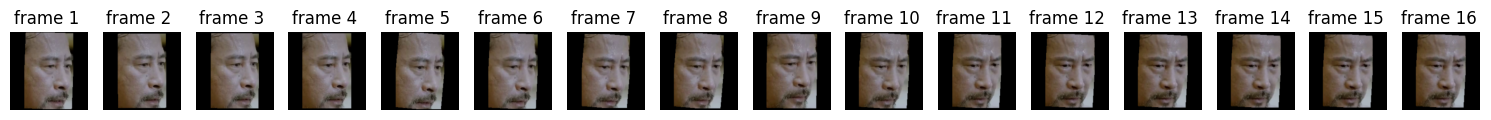

In [14]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np


# 可视化视频帧
plt.figure(figsize=(15, 3))
for i in range(16):  # 显示前16帧
    plt.subplot(1, 16, i+1)
    frame = video[:, i, :, :].permute(1, 2, 0).numpy()  # 调整形状为 (160, 160, 3)
    frame = (frame * video_conf['std'] + video_conf['mean']) * 255  # 反归一化
    frame = frame.astype(np.uint8)
    plt.imshow(frame)
    plt.axis('off')
    plt.title(f'frame {i+1} ')
plt.tight_layout()
plt.show()
